<a href="https://colab.research.google.com/github/davidandw190/pytorch-deep-learning-workspace/blob/main/notebooks/01_pytorch_dl_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch DeepLearning Workflow Fundamentals

The essence of machine learning and deep learning is to take some data from the past, build an algorithm (like a neural network) to discover patterns in it and use the discoverd patterns to predict the future.

There are many ways to do this and many new ways are being discovered all the time.

But since we're starting small, we'll start with a straight line, and we see if we can build a PyTorch model that learns the pattern of the straight line and matches it.





In [42]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

We're going to get torch, torch.nn (nn stands for neural network and this package contains the building blocks for creating neural networks in PyTorch) and matplotlib

In [43]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.3.0+cu121'

## 1.  Data (preparing and loading)

For now, we dont have any data, but lets create our own data.

Let's create our data as a straight line.

We'll use **linear regression** to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using **gradient descent**

In [44]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = weight * X + bias

X[:10], Y[:10], len(X), len(Y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

Beautiful! Now we're going to move towards building a model that can learn the relationship between X (features) and y (labels).


### Split data into training and test sets

We've got some data.

But before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

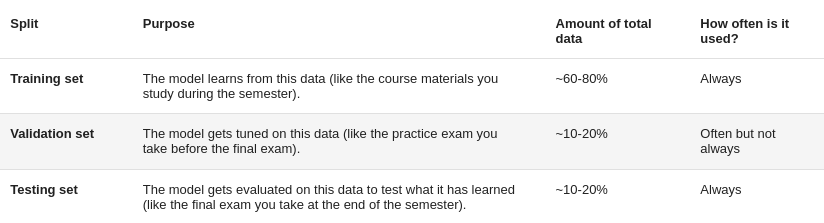

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

**Note**: When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it generalizes to unseen examples.

In [45]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

len(X_train), len(Y_train), len(X_test), len(Y_test)

(40, 40, 10, 10)

In [46]:
def plot_predictions(train_data=X_train,
                     train_labels=Y_train,
                     test_data=X_test,
                     test_labels=Y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in yellow
  plt.scatter(test_data, test_labels, c="y", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});


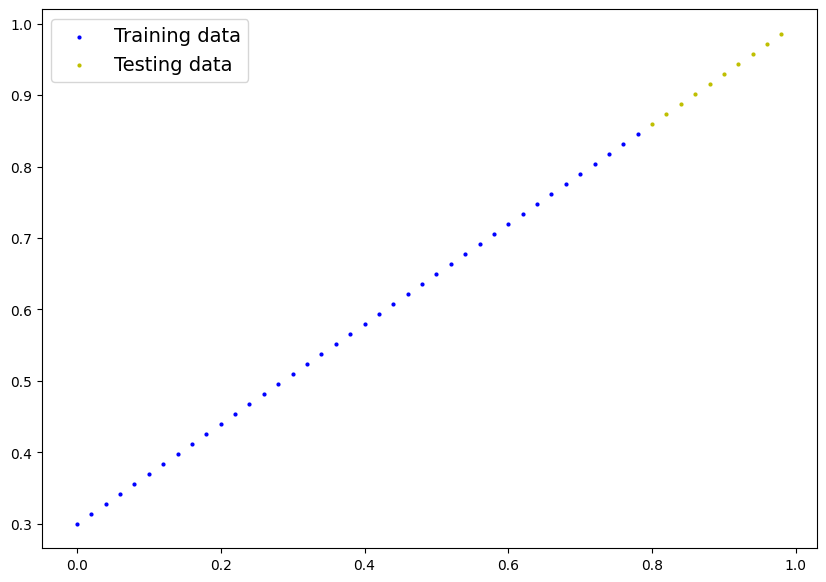

In [47]:
plot_predictions();

## 2. Build model

Let's replicate a standard linear regression model using pure PyTorch.

In [48]:
# Create a liner regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True)  # <- can we update this value with gradient descent?)

    self.bias = nn.Parameter(torch.randn(1,  # <- start with random bias (this will get adjusted as the model learns)
                                         dtype=torch.float),
                             requires_grad=True)

  # Forward defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
    return self.weight * x + self.bias # <- this is the linear regression formula (y = m*x + b)


### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

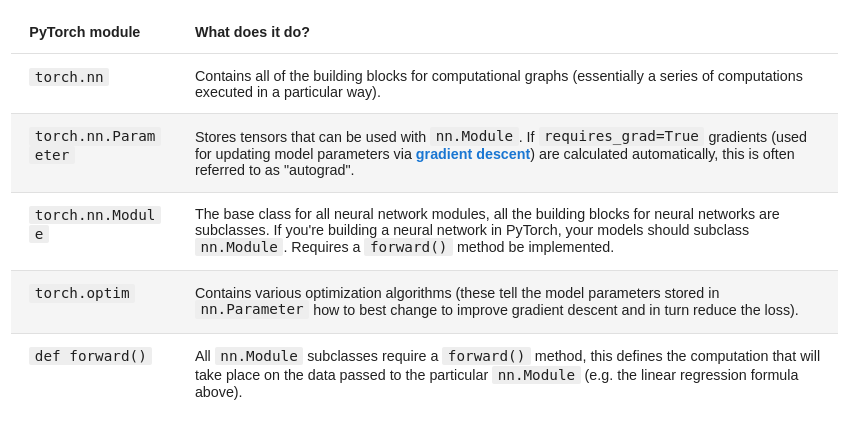

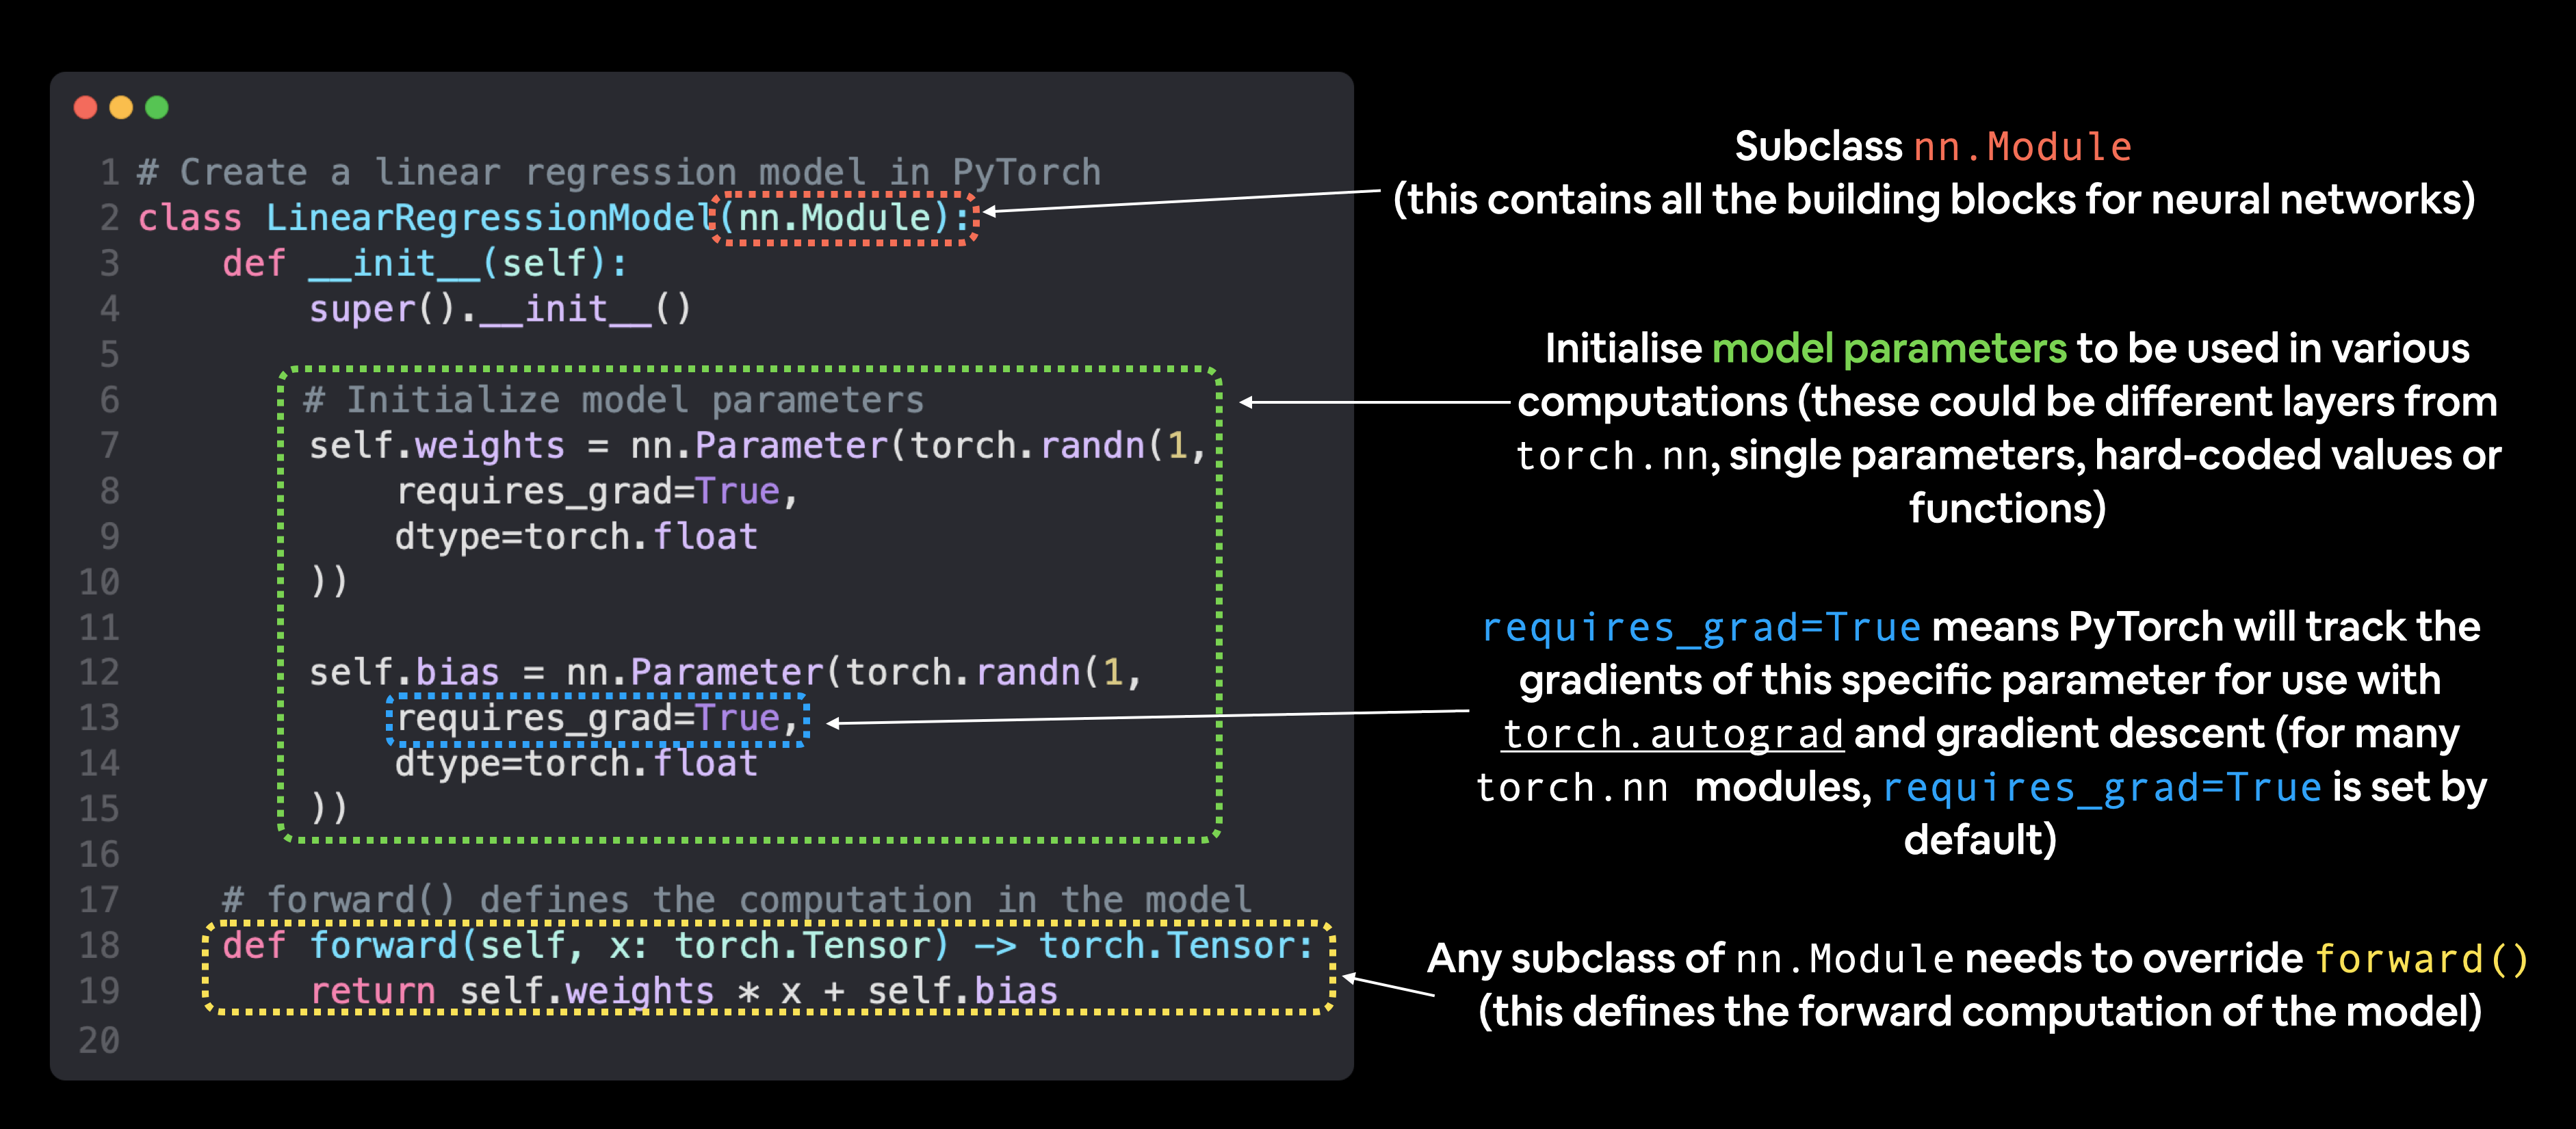

*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

### Checking the contents of a PyTorch model

So we can check out model parameters or whats inside out model by using `.parameters()`


In [49]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using `.state_dict()`.

In [50]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`.

Because our model starts with random values, right now it'll have poor predictive power.

To check this we can pass it the test data `X_test` to see how closely it predicts `Y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.




In [51]:
# Make predictions with model
with torch.inference_mode():
    Y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   Y_preds = model_0(X_test)


We used `torch.inference_mode()` as a context manager to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like **gradient tracking**, which is necessary for training but not for inference) to make forward-passes much faster.


In [52]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(Y_preds)}")
print(f"Predicted values:\n{Y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


Notice how there's one prediction value per testing sample.

This is because of the kind of data we're using. For our straight line, one X value maps to one y value.

However, machine learning models are very flexible. You could have 100 X values mapping to one, two, three or 10 y values. It all depends on what you're working on.

Our predictions are still numbers on a page, let's visualize them with our plot_predictions() function we created above.

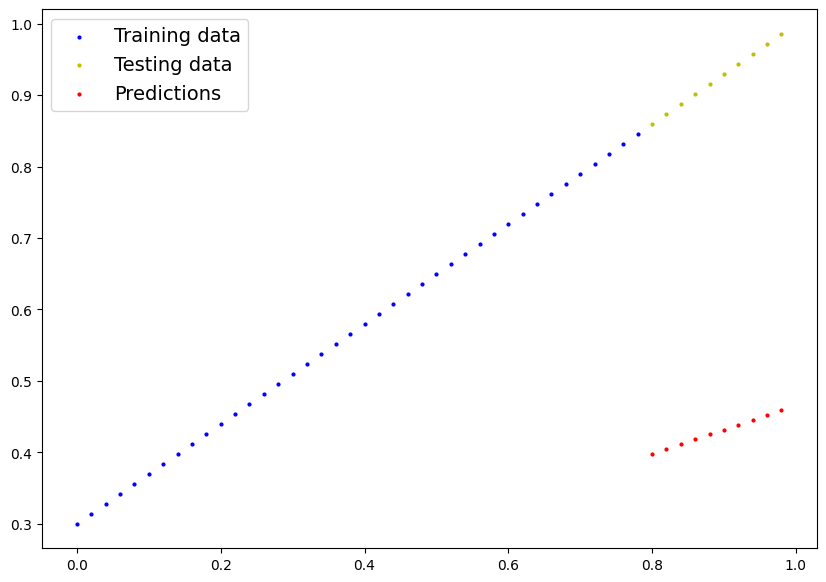

In [53]:
plot_predictions(predictions=Y_preds)